<center><img src="https://pure.ups.edu.ec/skin/headerImage/" width="300" height="300"></center>

<h1><center>Universidad Politecnica Salesiana</center></h1>
<h2><center>Simulacion Vacunacion</center></h2>


<b>Nombre: </b> Javier Vazquez

<b>Materia: </b> Simulacion


In [1]:
import simpy
import random

### Variables de Interes
* <b> Mesas Vacunacion: </b> mesas donde se atendera las pacientes, al mismo tiempo para vacunacion
* <b> Mesas Control: </b> numero mesas para el control de signos vitales <br>
* <b> Cola: </b>  numero personas que ya se encontraran en cola antes iniciar el proceso

Variables tiempos:
* <b> Tiempo simulacion: </b> 
* <b> Tiempo control: </b> 
* <b> Tiempo Vacunacion: </b> 
* <b> Tiempo Salida: </b> 

In [61]:
MESAS_VACUNACION=5 
MESAS_CONTROL=4 
TIEMPO_SIMULACION=350
INTERVALO_LLEGADA=7
TIEMPO_CONTROL=3
TIEMPO_VACUNACION=5
TIEMPO_SALIDA=1
COLA=20 

### Variables Auxiliares

In [62]:

estado_personas={}
personas_control={}
personas_vacunacion={}
tiempos_espera={}
tiempo_espera_final={}
tiempo_vacunacion_final={}
salida_personas={}

### Comprobar estado
verificar si una mesa ya sea de control o una mesa de vacunacion se encuentra habilitada para atender a la siguiente persona

In [63]:
MESAS_LIBRES_VACUNACION={}
for i in range(MESAS_VACUNACION):
    MESAS_LIBRES_VACUNACION[i]='Libre'
    
MESAS_LIBRES_CONTROL={}
for i in range(MESAS_CONTROL):
    MESAS_LIBRES_CONTROL[i]='Libre'


### Creacion de clases

Para esta practica unicamente se utilizo la clase de Vacunacion la cual dentro cuenta con los metodos necesarios para cada uno de los procesos, como el control de signos vitales, la vacunacion de las personas, metodos de verificacion y cambio de estados de las personas conforme van avanzando con el proceso

In [64]:




class Vacunacion(object):
    
    def __init__(self, environment, mesas_vacunacion):
        self.env= environment
        self.mesas_vacunacion = simpy.Resource(environment, mesas_vacunacion)

    def proceso_control(self,nombre, tiempo_control,idMesa):
        yield self.env.timeout(random.randint(tiempo_control-2, tiempo_control+4))
        if random.randint(1,100) <=10:
            estado_personas[nombre]='No pasa control'
            print('❌'*3, '[%s] no pasa el Control '%(nombre),'❌'*3)
        else:
            estado_personas[nombre]='Control'
        MESAS_LIBRES_CONTROL[idMesa]='Libre'
            
    
    def traslado_control(self):
        yield self.env.timeout(1)
        
    def proceso_vacunacion(self,nombre, tiempo_vacunacion, idmesa):
        #estado_personas[nombre]='Vacunada'
        yield self.env.timeout(random.randint(tiempo_vacunacion, tiempo_vacunacion+5))
        estado_personas[nombre]='Vacunado'
        MESAS_LIBRES_VACUNACION[idmesa]='Libre'
        
    def salida(self, tiempo):
        yield self.env.timeout(random.randint(tiempo, tiempo+2))
    
    def mesas_libres_vacunacion(self, num_mesa):
        if MESAS_LIBRES_VACUNACION.get(num_mesa) =='Libre':
            return True
        else:
            return False
    
    def mesas_libres_control(self, num_mesa):
        if MESAS_LIBRES_CONTROL.get(num_mesa) =='Libre':
            return True
        else:
            return False
 


### Logica modelo simulacion

In [65]:
def llegada_personas(env,nombre, vacunacion,tiempo_control, tiempo_vacunacion, cola,tiempo_salida):
    print('---> Llega [%s] a la cola hora %.2f.'%(nombre,env.now))
    estado_personas[nombre]='Cola'
    llegada=env.now
    tiempos_espera[nombre]=llegada
    with vacunacion.mesas_vacunacion.request() as mesas:
        yield mesas
        lista_cola=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Cola']
        for i in range(MESAS_CONTROL):
            if len(lista_cola)>0: 
                persona=lista_cola[0]
                if vacunacion.mesas_libres_control(i):
                    if not persona in personas_control:
                        MESAS_LIBRES_CONTROL[i]='Ocupada'
                        
                        personas_control[persona]=i
                        print('🛂 [%s] entra al control al hora %.2f CONTROL %s  luego de esperar %s minutos'%(persona,env.now, i+1, env.now-tiempos_espera[persona]))
                        tiempo_espera_final[persona]=env.now-tiempos_espera[persona]
                        yield env.process(vacunacion.proceso_control(persona, tiempo_control,i))
                        print('Sale del control [%s] a la hora %.2f libre CONTROL %s'%(persona, env.now, i+1))
                        
                #personas_pasan.append(persona)
                
                lista_cola.remove(persona)
        
        lista_control=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Control']
        for i in range(MESAS_VACUNACION):
            if len(lista_control)>0:
                persona_control=lista_control[0]
                if vacunacion.mesas_libres_vacunacion(i):
                    if not persona_control in personas_vacunacion:
                        MESAS_LIBRES_VACUNACION[i]='Ocupada'
                        personas_vacunacion[persona_control]=i
                        inicio_vacunacion=env.now
                        print('💉 La: [%s] entra a vacunarse al hora %.2f MESA %s '%(persona_control,env.now, i+1))
                        yield env.process(vacunacion.proceso_vacunacion(persona_control, tiempo_vacunacion,i)) # traslado a silla donde vacunacion 
                        print('Sale de vacunarse [%s] a la hora %.2f libre MESA %s se demoro %s minutos'%(persona_control, env.now, i+1, env.now-inicio_vacunacion))
                        tiempo_vacunacion_final[persona_control]=env.now-inicio_vacunacion
                lista_control.remove(persona_control)
        lista_salida=[key for key in list(estado_personas.keys()) if estado_personas[key]=='Vacunado' or estado_personas[key]=='No pasa control' ]
        for i in lista_salida:
            if not i in salida_personas:
                yield env.process(vacunacion.salida(tiempo_salida))
                print('<--- [%s] abandona las instalaciones a las %s'%(i, env.now))
                salida_personas[i]='salida'

### Ejecutar simulacion

In [66]:
def ejecutar_simulacion(env, mesas_vacunacion, intervalo_llegada,
                        tiempo_control, tiempo_vacunacion, tiempo_salida):
    vacunacion = Vacunacion(env, mesas_vacunacion)
    i=0
    for j in range(COLA):
        env.process(llegada_personas(env,'Persona-%d'%(i+1), vacunacion, tiempo_control, tiempo_vacunacion,j,tiempo_salida)) 
        i+=1
    while True:
        i+=1
        yield env.timeout(random.randint(intervalo_llegada-2, intervalo_llegada+2))
        env.process(llegada_personas(env,'Persona-%d'%(i), vacunacion,tiempo_control, tiempo_vacunacion,COLA+1,tiempo_salida))

print('-'*5,'Vacunacion JAVIER VAZQUEZ','-'*5,'\n')    
random.seed(77)
env= simpy.Environment()
env.process(ejecutar_simulacion(env, MESAS_VACUNACION, INTERVALO_LLEGADA, 
                                 TIEMPO_CONTROL, TIEMPO_VACUNACION, TIEMPO_SALIDA ))
env.run(until=TIEMPO_SIMULACION)

----- Vacunacion JAVIER VAZQUEZ ----- 

---> Llega [Persona-1] a la cola hora 0.00.
---> Llega [Persona-2] a la cola hora 0.00.
---> Llega [Persona-3] a la cola hora 0.00.
---> Llega [Persona-4] a la cola hora 0.00.
---> Llega [Persona-5] a la cola hora 0.00.
---> Llega [Persona-6] a la cola hora 0.00.
---> Llega [Persona-7] a la cola hora 0.00.
---> Llega [Persona-8] a la cola hora 0.00.
---> Llega [Persona-9] a la cola hora 0.00.
---> Llega [Persona-10] a la cola hora 0.00.
---> Llega [Persona-11] a la cola hora 0.00.
---> Llega [Persona-12] a la cola hora 0.00.
---> Llega [Persona-13] a la cola hora 0.00.
---> Llega [Persona-14] a la cola hora 0.00.
---> Llega [Persona-15] a la cola hora 0.00.
---> Llega [Persona-16] a la cola hora 0.00.
---> Llega [Persona-17] a la cola hora 0.00.
---> Llega [Persona-18] a la cola hora 0.00.
---> Llega [Persona-19] a la cola hora 0.00.
---> Llega [Persona-20] a la cola hora 0.00.
🛂 [Persona-1] entra al control al hora 0.00 CONTROL 1  luego de esper

* Como podemos observar primera instancia es la cantidad de personas que se han generado a la cola 
* Despues acorde a las mesas de control pasan las personas, sin tiempo de espera
* Posteriormente proceden a la mesa de vacunacion conforme van saliendo del proceso de control
* Se observa tambien como las personas van llegando segun el intervalo de tiempo propuesto
* Finalmente la persona vacuna procede abandonar las instalaciones

## Resultados

In [71]:
vacunados=0
total=0
no_atendidos=0
for key in estado_personas:
    total+=1
    if estado_personas[key]=='Vacunado': vacunados+=1
    if estado_personas[key]=='No pasa control': no_atendidos+=1
print('-'*70,'\n* Total personas: ', total)
print('* Personas que no pasaron el control: ', no_atendidos)
print('* Personas vacunadas: ', vacunados)
print('* Tiempo promedio espera en la cola: ',sum(list(tiempo_espera_final.values()))/len(tiempo_espera_final))
print('* Tiempo promedio Vacunacion: ', sum(list(tiempo_vacunacion_final.values()))/len(tiempo_vacunacion_final),'\n','-'*70)

---------------------------------------------------------------------- 
* Total personas:  68
* Personas que no pasaron el control:  8
* Personas vacunadas:  58
* Tiempo promedio espera en la cola:  13.75
* Tiempo promedio Vacunacion:  7.758620689655173 
 ----------------------------------------------------------------------


### Grafica tiempos espera

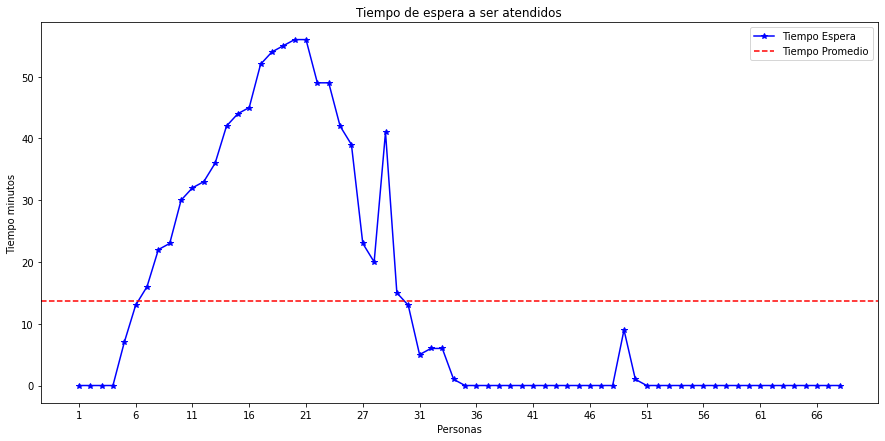

In [68]:
import matplotlib.pyplot as plt
promedio={}
for i in list(tiempo_espera_final.keys()):
    #print(i.split('-'))
    promedio[i.split('-')[1]]=tiempo_espera_final[i]
plt.figure(figsize = (15,7))
plt.plot(list(promedio.keys()),list(promedio.values()),'*-b')
plt.xticks(list(promedio.keys())[::5])
plt.axhline(y=sum(list(tiempo_espera_final.values()))/len(tiempo_espera_final), xmin=0.0, xmax=1,color='red',linestyle="--")

plt.title('Tiempo de espera a ser atendidos')
plt.xlabel('Personas')
plt.ylabel('Tiempo minutos')
plt.legend(['Tiempo Espera','Tiempo Promedio'])

### Grafico tiempos vacunacion

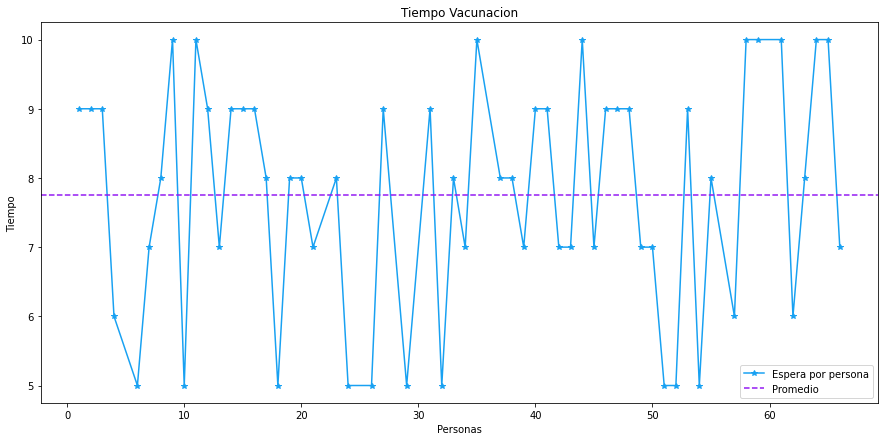

In [69]:
promedio_vacunacion={}
for i in list(tiempo_vacunacion_final.keys()):
    #print(i.split('-'))
    promedio_vacunacion[int(i.split('-')[1])]=tiempo_vacunacion_final[i]
promedio_vacunacion=dict(sorted(promedio_vacunacion.items()))
plt.figure(figsize = (15,7))
plt.plot(promedio_vacunacion.keys(), promedio_vacunacion.values(),'*-', color='#18A1F2')
plt.axhline(y=sum(list(tiempo_vacunacion_final.values()))/len(tiempo_vacunacion_final), xmin=0.0, xmax=1,color='#9318F2',linestyle="--")
plt.title('Tiempo Vacunacion')
plt.xlabel('Personas')
plt.ylabel('Tiempo')
plt.legend(['Espera por persona', 'Promedio'])

### Grafico Personas 

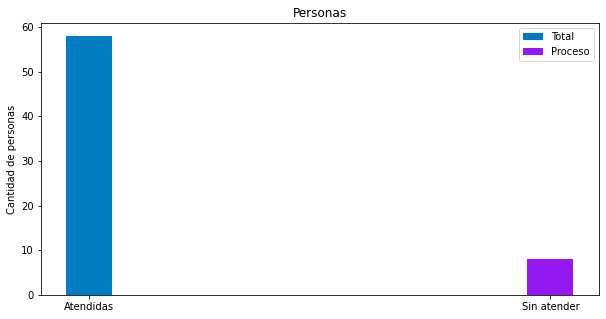

In [70]:
x = [1,2]
tags = ['Atendidas','Sin atender']
fig, ax = plt.subplots(figsize=(10,5))
bar1 = ax.bar(x[0], len(promedio_vacunacion), 0.1, label='Total', color="#007CC2")
bar2 = ax.bar(x[1], no_atendidos, 0.1, label='Proceso', color="#9318F2")
ax.set_ylabel('Cantidad de personas')
ax.set_title('Personas')
ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.legend(loc="upper right")

plt.show()

---
### Conclusion

Este modelo de simulacion nos permite ir analizando como las personas van pasando por las diferentes etapas que conlleva vacunarse, el tiempo que se demora en cada etapa y como esto se puede mejorar, como es el caso de las mesas de vacunacion ya que este proceso tiene mayor tiempo demora que el proceso del control signos vitales, aumentar las mesas significaria una mayor cantidad de personas atendidas y no tendriamos a muchas personas en cola esperando su turno